# Covered Calls Leap Trader

## Imports

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
import yfinance as yf

from dateutil.relativedelta import relativedelta

from tqdm import tqdm
tqdm.pandas()

## Params

In [2]:
# Difference between long and short term gains (federal change shown below).
# However state by state laws are different... Feel free to look at 
# Input `TAX_ADVANTAGE` as a percent
TAX_ADVANTAGE = .17

# Input `TAX_RATE` as a percent
TAX_RATE = 0.37 + .1075

# Score risk tolerance by standard deviations (cumulative coverage percentage below)
RISK_TOLERANCE = 1

# How much each option takes to trade (this number is based of Schwab)
FEE = .65

# Get options data `AFTER_DATE`
AFTER_DATE = pd.to_datetime('2000-01-01')
BEFORE_DATE = pd.to_datetime('2025-08-08')

# Sets a maximum days to expiration
MAX_DAYS_TILL_EXPIRATION = 400

# Sets the ticker to trade
TICKERS = ['QQQ', 'SPY']

### This shows the difference between long and short term gains (Last Updated 2024)

#### Single Filers

| Money Made                | Tax Rate Difference (Short-Term - Long-Term) |
|---------------------------|----------------------------------------------|
| $0 – $47,025              | 10% – 0% = 10% or 12% – 0% = 12%            |
| $47,026 – $100,525        | 22% – 15% = 7%                              |
| $100,526 – $191,950       | 24% – 15% = 9%                              |
| $191,951 – $243,725       | 32% – 15% = 17%                             |
| $243,726 – $518,900       | 35% – 15% = 20%                             |
| $518,901 or more          | 37% – 20% = 17%                             |

#### Married Filing Jointly

| Money Made                | Tax Rate Difference (Short-Term - Long-Term) |
|---------------------------|----------------------------------------------|
| $0 – $94,050              | 10% – 0% = 10% or 12% – 0% = 12%            |
| $94,051 – $201,050        | 22% – 15% = 7%                              |
| $201,051 – $383,900       | 24% – 15% = 9%                              |
| $383,901 – $487,450       | 32% – 15% = 17%                             |
| $487,451 – $583,750       | 35% – 15% = 20%                             |
| $583,751 or more          | 37% – 20% = 17%                             |


### This Shows The Percent Chance That A Return Happens Outside Said Standard Devitation Range
| **n (Number of Standard Deviations)** | **Cumulative Coverage (%)**    |
|----------------------------------------|----------------------------------|
| 1σ                                     | 68.27%                          |
| 2σ                                     | 95.45%                          |
| 3σ                                     | 99.73%                          |
| 4σ                                     | 99.9937%                        |
| 5σ                                     | 99.99994%                       |
| 6σ                                     | 99.9999998%                     |
| 7σ                                     | 99.9999999997%                  |
| 8σ                                     | 99.99999999999996%              |
| 9σ                                     | ~100%                           |
| 10σ                                    | ~100%                           |


## Read In File

In [3]:
# Initialize a dictionary to hold dataframes for each ticker
portfolio_option_data = {}

# Iterate through tickers and set dictionary to hold proper data
for TICKER in TICKERS:
    
    print(TICKER)
    
    # Read data
    portfolio_option_data[TICKER] = pd.read_parquet(f'../read_data/data/clean/{TICKER}.parquet')

QQQ
SPY


## Leap Reader

### Group By Leap and Set Restriction For Max Days Until Expiration

In [4]:
portfolio_leap_options = {}

# Find best leap contracts
for TICKER in TICKERS:
    print(TICKER)

    # Group by date
    portfolio_leap_options[TICKER] = portfolio_option_data[TICKER].groupby(['date']).progress_apply(

        # Iterate through each group (for other code readers, think about the following code as a function for each `date` within the all_options_data dataframe)
        lambda group: group.loc[

            # Get first `expiration_date` that surpasses year from `date`... aka first leap
            (group['expiration_date'] == group.loc[
                group['expiration_date'] > (group.name + relativedelta(years=1))]
                ['expiration_date'].min())
            
            ]

            # Of these `expiration_date`s, make sure that `days_till_expiration` < criteria
            .loc[group['days_till_expiration'] < MAX_DAYS_TILL_EXPIRATION]

            # Of these `expiration_date`s with aforementioned critetia, obtain the option with the smallest `strike_distance`
            .nsmallest(1, 'strike_distance')

            # Output these column
            [['expiration_date', 'strike', 'days_till_expiration', 'call_price', 'stock_price']]

        # Reset index so date is column and drop added `level_1` index
        ).reset_index().drop(columns = ['level_1'])

QQQ


100%|██████████| 3017/3017 [00:03<00:00, 803.44it/s] 


SPY


100%|██████████| 3500/3500 [00:04<00:00, 762.23it/s]


In [5]:
portfolio_leap_options[TICKER]

,date,expiration_date,strike,days_till_expiration,call_price,stock_price
0,2010-06-03,2011-06-17,110.0,379,10.855,110.71
1,2010-06-04,2011-06-17,105.0,378,11.965,107.00
2,2010-06-07,2011-06-17,105.0,375,11.155,105.49
3,2010-06-08,2011-06-17,105.0,374,11.685,106.57
4,2010-06-09,2011-06-17,105.0,373,11.370,106.02
...,...,...,...,...,...,...
1493,2023-12-22,2025-01-17,475.0,392,40.090,473.68
1494,2023-12-26,2024-12-31,475.0,371,40.835,475.61
1495,2023-12-27,2024-12-31,476.0,370,39.920,476.47
1496,2023-12-28,2024-12-31,477.0,369,39.290,476.73


## Stock Stats

## Find Trade Sell Date
 - option_sell_date: determines when the leap should be sold for each trading day so that later trading strategies can be altered without rerun
   - option_sell_date_helper: sets the boolen for rollover based on certain strategy
### Strategies 
 - Benchmark:
   - no buyback
   - no rollover
 - s1: 
   - buyback perfectish
   - rollover near strike price
 - s2:
   - buyback based off percent gain
   - rollover near strike price

In [203]:
# Function help determine when to sell option
def option_sell_date_helper(target_option, target_option_day_0, leaps, fee, tax_advantage, strategy):
    # Get leap on day of target_option_data... aka the leap that would be rolled into
    rollover_leap = leaps.loc[leaps['date'] == target_option['date']]

    if not rollover_leap.empty:

        # Benchmark leap strategy
        if strategy == 'benchmark':
            return False

        elif strategy == 's30':
            rollover_bool = (target_option_day_0['call_price'] * 0.3 > target_option['call_price']) | (target_option_day_0['strike'] + target_option_day_0['call_price'] < target_option['stock_price'])
            return rollover_bool

# Function to determine when to sell an option
def option_sell_date(option, all_leap_options, all_option_data, fee, tax_advantage, strategy):

    # Gets useful `all_leap_options` to consider
    leaps = all_leap_options.loc[(all_leap_options['date'] > option['date']) & (all_leap_options['date'] < option['expiration_date'])]

    # Follows the `option` from `date` to `expiration date`
    target_option_data = all_option_data.loc[(all_option_data['expiration_date'] == option['expiration_date']) & (all_option_data['strike'] == option['strike']) & (all_option_data['date'] > option['date'])]

    # Determine if option should roll over on each data
    target_option_data['sell_bool'] = target_option_data.apply(option_sell_date_helper, args= [option, leaps, fee, tax_advantage, strategy,], axis=1)

    # If there exists a true `sell_bool`
    if target_option_data['sell_bool'].any() == True:
        
        # Set `sell_date` to minimum `target_option_date`
        sell_date = target_option_data.loc[target_option_data['sell_bool'] == True]['date'].min()

        # Set `tax_rate` to short
        tax_rate = 'short'

    # If there does not exist a true `sell_bool`
    else:
        # Set `sell_date` to `expiration_date`
        sell_date = option['expiration_date']

        # Set `tax_rate` to short
        tax_rate = 'long'

    # Set `call_last_price` to the last price in the target_option_data
    call_last_price = target_option_data.loc[target_option_data['date'] == sell_date]['call_price']

    # If `call_last_price` is known set it
    if not call_last_price.empty:
        call_last_price = call_last_price.iloc[0]
    # Else set to None
    else:
        call_last_price = None

    return pd.Series(data = {'sell_date' : sell_date, 'call_last_price' : call_last_price, 'tax_rate' : tax_rate})

### Running Through Each Strategy And Ticker

In [204]:
# Initialize a dictionary of dataframes
all_strategies = {}
all_strats = ['s30']

len(all_strats)

1

In [205]:
# # Initialize a dictionary for each benchmark trading strategy
# portfolio_benchmark = {}

# # Iterate through tickers
# for TICKER in TICKERS:
#     print(TICKER)

#     # Copy full option data
#     options_benchmark = portfolio_leap_options[TICKER].copy()

#     # Get the leap options for each day
#     options_benchmark[['sell_date', 'call_last_price', 'tax_rate']] = portfolio_leap_options[TICKER].progress_apply(option_sell_date, args=[portfolio_leap_options[TICKER], portfolio_option_data[TICKER], FEE, TAX_ADVANTAGE, 'benchmark',], axis=1)

#     # Add to portfolio
#     portfolio_benchmark[TICKER] = options_benchmark

#     # Print count of leaps in each year
#     print(portfolio_benchmark[TICKER].groupby(portfolio_benchmark[TICKER]['date'].dt.year)['date'].count())

# all_strategies['benchmark'] = portfolio_benchmark

In [206]:
# Iterate through strategies
for s_i, strategy in enumerate(all_strats):
    # Initialize a dictionary for each s1 trading strategy
    single_strat = {}

    # Iterate through tickers
    for s_t, TICKER in enumerate(TICKERS):
        print(f'{TICKER} || {strategy} || {(s_i) * 2 + s_t + 1} / {len(TICKERS) * len(all_strats)}')

        # Copy full option data
        options = portfolio_leap_options[TICKER].copy()

        # Get the leap options for each day
        options[['sell_date', 'call_last_price', 'tax_rate']] = portfolio_leap_options[TICKER].progress_apply(option_sell_date, args=[portfolio_leap_options[TICKER], portfolio_option_data[TICKER], FEE, TAX_ADVANTAGE, strategy,], axis=1)

        # Add to portfolio
        single_strat[TICKER] = options
    
    # Add to all strategies
    all_strategies[strategy] = single_strat

QQQ || s30 || 1 / 2


100%|██████████| 701/701 [00:34<00:00, 20.11it/s]


SPY || s30 || 2 / 2


100%|██████████| 1498/1498 [01:25<00:00, 17.53it/s]


In [207]:
single_strat['QQQ']

,date,expiration_date,strike,days_till_expiration,call_price,stock_price,sell_date,call_last_price,tax_rate
0,2012-01-03,2013-01-18,57.00,381,5.400,56.90,2012-11-21,7.08,short
1,2012-01-04,2013-01-18,57.00,380,5.450,57.14,2012-11-21,7.08,short
2,2012-01-05,2013-01-18,58.00,379,5.105,57.61,2012-11-21,6.15,short
3,2012-01-06,2013-01-18,58.00,378,5.120,57.78,2012-11-21,6.15,short
4,2012-01-09,2013-01-18,58.00,375,4.985,57.63,2012-11-21,6.15,short
...,...,...,...,...,...,...,...,...,...
696,2023-12-22,2025-01-17,410.00,392,42.900,408.44,2025-01-17,NaN,long
697,2023-12-26,2025-01-17,410.00,388,44.260,410.88,2025-01-17,NaN,long
698,2023-12-27,2025-01-17,409.78,387,44.295,411.50,2025-01-17,NaN,long
699,2023-12-28,2025-01-17,409.78,386,44.580,411.21,2025-01-17,NaN,long


# RUN POINT

## Get Leap Options After Date

In [208]:
strategies = {}

# Iterate through tickers
for strategy in all_strategies:
    
    # Initialize strategies for strategy
    strategies[strategy] = {}

    # Iterate through strategies
    for TICKER in TICKERS:
        
        # Get leaps after date and before date
        strat = all_strategies[strategy][TICKER].loc[(all_strategies[strategy][TICKER]['date'] > AFTER_DATE) & (all_strategies[strategy][TICKER]['expiration_date'] < BEFORE_DATE)]

        # If the length is > 1
        if len(strat) > 1:
            strategies[strategy][TICKER] = strat


## Determine Which Options To Trade

In [209]:
def leaps_to_trade(leap_options):
    # Set first leap to the first `leap_options['date']`
    leap_dates = [leap_options['date'].iloc[0]]

    # Set the first `sell_date` to the sell date of the first `leap_options['date']`
    sell_date = leap_options.loc[leap_options['date'] == leap_dates[-1]]['sell_date'].iloc[0]

    # Determines if it was a quick or slow trade
    type = leap_options.loc[leap_options['date'] == leap_dates[-1]]['tax_rate'].iloc[0]

    # Gets previous stock sell price
    previous_price = leap_options.loc[leap_options['date'] == leap_dates[-1]]['stock_price'].iloc[0]

    # Iterate through the `leap_options` until the `sell_date` > the last `leap_options['date']`
    while sell_date < leap_options['date'].iloc[-1]:
        # pct_margin = 1
        # if not leap_options.loc[(leap_options['date'] > sell_date) & (leap_options['stock_price'] >= (previous_price * pct_margin))]['date'].empty:
        #         leap_dates.append(leap_options.loc[(leap_options['date'] > sell_date) & (leap_options['stock_price'] >= (previous_price * pct_margin))]['date'].iloc[0])
        # else:
        #     break

        # pct_margin = .97

        leap_dates.append(leap_options.loc[leap_options['date'] > sell_date]['date'].iloc[0])

        # if strategy == 'benchmark':
        #     if type == 'long':
        #         # Append the first `leap_options['date']` thats larger than the previous `sell_date`
        #         leap_dates.append(leap_options.loc[leap_options['date'] > sell_date]['date'].iloc[0])
        #     elif type == 'short':
                
        #         # Append the first `leap_options['date']` thats larger than the previous `sell_date` and within a margin of the prior stock price
        #         if not leap_options.loc[(leap_options['date'] > sell_date) & (leap_options['stock_price'] >= previous_price * pct_margin)]['date'].empty:
        #             leap_dates.append(leap_options.loc[(leap_options['date'] > sell_date) & (leap_options['stock_price'] >= previous_price * pct_margin)]['date'].iloc[0])
        #         else:
        #             break

        # elif 's' in strategy:
        #     if type == 'long':
        #         # Append the first `leap_options['date']` thats larger than the previous `sell_date`
        #         leap_dates.append(leap_options.loc[leap_options['date'] > sell_date]['date'].iloc[0])
        #     elif type == 'short':
        #         # Append the first `leap_options['date']` thats larger than the previous `sell_date` and within a margin of the prior stock price
        #         if not leap_options.loc[(leap_options['date'] > sell_date) & (leap_options['stock_price'] >= previous_price * pct_margin)]['date'].empty:
        #             leap_dates.append(leap_options.loc[(leap_options['date'] > sell_date) & (leap_options['stock_price'] >= previous_price * pct_margin)]['date'].iloc[0])
        #         else:
        #             break

        # leap_dates.append(leap_options.loc[leap_options['date'] > sell_date]['date'].iloc[0])

        # Set `sell_date` to the expiration date of the previously appended `leap_dates`
        sell_date = leap_options.loc[leap_options['date'] == leap_dates[-1]]['sell_date'].iloc[0]

        # Determines if it was a quick or slow trade
        type = leap_options.loc[leap_options['date'] == leap_dates[-1]]['tax_rate'].iloc[0]

        # Gets previous stock sell price
        previous_price = leap_options.loc[leap_options['date'] == leap_dates[-1]]['stock_price'].iloc[0]

    return leap_dates

# Initiate a dictionary to find each trade performed
portfolio_trades = {}

# Iterate through each strategy
for strategy in strategies:
    # Initialize strategy
    portfolio_trades[strategy] = {}

    # Iterate through each ticker
    for TICKER in TICKERS:
        print(f'{strategy.upper()} : {TICKER}')

        leap_dates = leaps_to_trade(strategies[strategy][TICKER])

        # Get all the options from `leap_options` with the starting dates within `leap_dates`
        portfolio_trades[strategy][TICKER] = strategies[strategy][TICKER].loc[strategies[strategy][TICKER]['date'].isin(leap_dates)].reset_index(drop=True)

S30 : QQQ
S30 : SPY


In [210]:
portfolio_trades['s30']['SPY']

,date,expiration_date,strike,days_till_expiration,call_price,stock_price,sell_date,call_last_price,tax_rate
0,2010-06-03,2011-06-17,110.0,379,10.855,110.71,2010-12-01,14.540,short
1,2010-12-02,2011-12-16,123.0,379,9.575,122.57,2011-02-28,14.545,short
2,2011-03-01,2012-03-16,131.0,380,9.335,130.93,2011-08-23,2.425,short
3,2011-08-24,2012-09-21,118.0,394,11.280,118.10,2012-01-12,16.445,short
4,2012-01-13,2013-01-18,130.0,371,10.055,128.95,2012-08-21,13.915,short
5,2012-08-22,2013-09-20,142.0,394,10.740,141.76,2013-02-19,13.435,short
6,2013-02-20,2014-03-21,151.0,393,8.640,151.41,2013-05-17,19.135,short
7,2013-05-20,2014-06-20,167.0,396,9.845,166.93,2013-11-15,16.095,short
8,2013-11-18,2014-12-19,179.0,396,10.690,179.43,2014-05-23,14.510,short
9,2014-05-27,2015-06-19,191.0,388,9.960,191.52,2014-09-05,15.330,short


## Trade Options

In [211]:
def invest_earnings(leap_trade, option_data, stock_data, cash, tax_rate, fee, equity_holdings=0, loss_carry_forward=0.0):
    if tax_rate == 'long':
        tax_rate_val = 0.17 + 0.1075
    elif tax_rate == 'short':
        tax_rate_val = 0.37 + 0.1075

    start_date = leap_trade['date'].iloc[0]
    sell_date = leap_trade['sell_date'].iloc[0]
    start_stock_price = stock_data.iloc[0]
    end_stock_price = stock_data.iloc[-1]
    strike = leap_trade['strike'].iloc[0]
    call_price = leap_trade['call_price'].iloc[0]
    call_last_price = leap_trade['call_last_price'].iloc[0]

    initial_cash = cash
    initial_equity = equity_holdings

    equity_purchase_history = []
    option_purchase_history = []
    options_purchased = 0

    # If equity holdings != 0 then we should sell our first round of options
    if equity_holdings > 0:
        # Sell covered calls
        contracts_to_sell = (equity_holdings) // 100 - options_purchased
        option_purchase_history.append(contracts_to_sell)
        options_purchased += contracts_to_sell

        # Determine how much profit was made from selling options
        gross_premium = contracts_to_sell * call_price * 100

        # Include fees (0.65 cents on Schwabb) for option purchase
        fee_total = contracts_to_sell * fee

        # Calculate net premium made and update cash
        net_premium = gross_premium - fee_total
        cash += net_premium

    # If shares can be bought
    while cash >= start_stock_price:
        # Purchase shares and update cash
        shares_to_buy = int(cash // start_stock_price)
        equity_holdings += shares_to_buy
        equity_purchase_history.append(shares_to_buy)
        cash -= shares_to_buy * start_stock_price

        # Sell covered calls
        contracts_to_sell = (equity_holdings) // 100 - options_purchased
        option_purchase_history.append(contracts_to_sell)
        options_purchased += contracts_to_sell

        # Determine how much profit was made from selling options
        gross_premium = contracts_to_sell * call_price * 100

        # Include fees (0.65 cents on Schwabb) for option purchase
        fee_total = contracts_to_sell * fee

        # Calculate net premium made and update cash
        net_premium = gross_premium - fee_total
        cash += net_premium

    # Initialize realized profits
    realized_option_profit = 0.0
    realized_stock_profit = 0.0

    # Daily Return
    daily_values = []
    for i in range(len(stock_data)):
        stock_p = stock_data.iloc[i]
        opt_p = option_data.iloc[i]

        # Value of shares
        shares_value = equity_holdings * stock_p

        # Value of the short call (negative since we sold calls)
        short_call_value = options_purchased * (opt_p * 100)

        # Net portfolio value on day i
        day_value = cash + shares_value - short_call_value
        daily_values.append(day_value)

    # Daily Return
    daily_values_immediate = []
    for i in range(len(stock_data)):
        stock_p = stock_data.iloc[i]

        # Value of shares
        option_shares_value = np.minimum(stock_p, start_stock_price) * options_purchased * 100
        extra_shares_value = (equity_holdings - (options_purchased * 100)) * stock_p

        # Boolean for stock > strike
        stock_over_strike_bool = stock_p > strike

        # Boolean for losing money
        losing_money_bool = stock_p < start_stock_price - strike 

        # Net portfolio value on day i
        day_value = cash + option_shares_value + extra_shares_value
        daily_values_immediate.append(day_value)


    # Determine outcome

    # Determine profit
    total_initial_premium = options_purchased * (call_price * 100 - fee)

    # If option rollover (aka short tax rate)
    if tax_rate == 'short':
        # Buy back calls and include fees
        buyback_cost = options_purchased * call_last_price * 100
        closing_fee = options_purchased * fee
        cash -= (buyback_cost + closing_fee)

        # Determine how much you made off of rollover including fees
        realized_option_profit = total_initial_premium - (buyback_cost + closing_fee)

        # Still hold stocks so no realized profit
        realized_stock_profit = 0.0
    
    # If held to expiration
    else:
        # If last stock price is above the strike
        if end_stock_price > strike:
            # Determine how many shares will be sold
            shares_assigned = options_purchased * 100

            # Add cash from sales
            cash += (strike * shares_assigned)

            # Determine how much money was made/lost from stocks
            realized_stock_profit = (strike - start_stock_price) * shares_assigned

            # Determine how much money was made from options
            realized_option_profit = total_initial_premium

            # Subtract equity from holdings
            equity_holdings -= shares_assigned

        # If strike is below last stock price
        else:
            # Determine how much money was made from options
            realized_option_profit = total_initial_premium

            # Still hold stocks so no realized profit
            realized_stock_profit = 0.0

    if end_stock_price > strike:
        loss_carry_forward = (end_stock_price - strike) * options_purchased * 100

    # Combine main profits
    total_realized_profit = realized_option_profit + realized_stock_profit

    # If after main transactions cash < 0... aka we needed to buy back shares
    if cash < 0:
        shares_to_sell = np.ceil(-cash / end_stock_price)

        equity_holdings -= shares_to_sell
        sale_revenue = shares_to_sell * end_stock_price
        cash += sale_revenue

        # Realized gain/loss from forced sale:
        forced_sale_profit = (end_stock_price - start_stock_price) * shares_to_sell
        total_realized_profit += forced_sale_profit

        daily_values_immediate[-1] = cash + equity_holdings * end_stock_price

    # Calculate final P/L
    final_value = cash + equity_holdings * end_stock_price
    initial_value = initial_cash + initial_equity * start_stock_price
    total_pl = final_value - initial_value

    # Set daily_values series
    daily_values_s = pd.Series(data=daily_values, index=stock_data.index, name="daily_values")
    daily_values_immediate_s = pd.Series(data=daily_values_immediate, index=stock_data.index, name="daily_values_immediate")

    return {
        'date': start_date,
        'sell_date': sell_date,
        'tax_scenario': tax_rate,
        'initial_cash' : initial_cash,
        'final_cash': cash,
        'initial_equity' : initial_equity,
        'final_equity_holdings': equity_holdings,
        'realized_option_profit': realized_option_profit,
        'realized_stock_profit': realized_stock_profit,
        'total_pl': total_pl,
        'initial_value' : initial_value,
        'final_value' : final_value,
        'equity_purchase_history': equity_purchase_history,
        'option_purchase_history': option_purchase_history,
        'loss_carry_forward': loss_carry_forward,
        'daily_values' : daily_values_s,
        'pct_shield' : call_price / start_stock_price,
        'daily_values_immediate' : daily_values_immediate_s,
        'initial_call_price' : call_price,
        'last_call_price' : call_last_price,
        'initial_stock_price' : start_stock_price,
        'last_stock_price' : end_stock_price
    }


In [212]:
# Initialize results
portfolio_results = {}

# Iterate through strategies
for s_i, strategy in enumerate(portfolio_trades):
    if strategy != 's22':
        # Initialize a dict for each strategy
        portfolio_results[strategy] = {}

        # Iterate through tickers
        for s_t, TICKER in enumerate(TICKERS):
            print(f'{TICKER} || {strategy} || {(s_i) * 2 + s_t + 1} / {len(TICKERS) * len(portfolio_trades)}')
            # Initialize variables for trading
            initial_cash = 100000
            initial_equity_holdings = 0
            loss_carry_forward = 0.0
            current_cash = initial_cash
            current_equity = initial_equity_holdings
            results = [{
                'date': portfolio_trades[strategy][TICKER]['date'].min(),
                'sell_date': portfolio_trades[strategy][TICKER]['date'].min(),
                'tax_scenario': None,
                'initial_cash': initial_cash,
                'final_cash': initial_cash,
                'initial_equity': 0,
                'final_equity_holdings': 0,
                'realized_option_profit': 0,
                'realized_stock_profit': 0,
                'total_pl': 0,
                'initial_value': initial_cash,
                'final_value': initial_cash,
                'equity_purchase_history': [],
                'option_purchase_history': [],
                'loss_carry_forward': loss_carry_forward,
                'daily_values' : pd.Series(),
                'pct_shield' : 0,
                'daily_values_immediate' : pd.Series(),
                'initial_call_price' : 0,
                'last_call_price' : 0,
                'initial_stock_price' : 0,
                'last_stock_price' : 0
            }]

            for i in range(len(portfolio_trades[strategy][TICKER])):
                # Get trade
                trade = portfolio_trades[strategy][TICKER].iloc[i:i+1]

                # Get stock data over the time of trade
                stock_data = portfolio_option_data[TICKER].loc[
                    (portfolio_option_data[TICKER]['date'] >= trade['date'].iloc[0]) &
                    (portfolio_option_data[TICKER]['date'] <= trade['sell_date'].iloc[0])
                ].groupby('date')['stock_price'].first()
                
                call_option_data = portfolio_option_data[TICKER].loc[
                    (portfolio_option_data[TICKER]['date'] >= trade['date'].iloc[0]) &
                    (portfolio_option_data[TICKER]['date'] <= trade['sell_date'].iloc[0]) &
                    (portfolio_option_data[TICKER]['strike'] == trade['strike'].iloc[0]) &
                    (portfolio_option_data[TICKER]['expiration_date'] == trade['expiration_date'].iloc[0])
                ][['call_price', 'date']]

                # Set the index to 'date'
                call_option_data = call_option_data.set_index('date')['call_price']

                stock_data = stock_data[stock_data.index.isin(call_option_data.index)]
                call_option_data = call_option_data[call_option_data.index.isin(stock_data.index)]

                # Call the invest_earnings function
                trade_result = invest_earnings(
                    leap_trade=trade,
                    option_data = call_option_data,
                    stock_data=stock_data,
                    cash=current_cash,
                    tax_rate=trade['tax_rate'].iloc[0],
                    fee=FEE,
                    equity_holdings=current_equity,
                    loss_carry_forward=loss_carry_forward,
                )

                if (i + 1) != len(portfolio_trades[strategy][TICKER]):
                    next_trade = portfolio_trades[strategy][TICKER].iloc[i+1:i+2]
                    
                    in_between_stock_data = portfolio_option_data[TICKER].loc[
                        (portfolio_option_data[TICKER]['date'] > trade['sell_date'].iloc[0]) &
                        (portfolio_option_data[TICKER]['date'] < next_trade['date'].iloc[0])
                    ].groupby('date')['stock_price'].first()
                    time_between_growth = trade_result['final_equity_holdings'] * (in_between_stock_data) + trade_result['final_cash']
                    trade_result['daily_values'] = pd.concat([trade_result['daily_values'], time_between_growth], axis=0)
                else:
                    
                    in_between_stock_data = portfolio_option_data[TICKER].loc[
                        (portfolio_option_data[TICKER]['date'] > trade['sell_date'].iloc[0]) &
                        (portfolio_option_data[TICKER]['date'] < BEFORE_DATE)
                    ].groupby('date')['stock_price'].first()
                    time_between_growth = trade_result['final_equity_holdings'] * (in_between_stock_data) + trade_result['final_cash']

                    trade_result['daily_values'] = pd.concat([trade_result['daily_values'], time_between_growth], axis=0)

                    
                # Store the results
                results.append(trade_result)

                # Update running totals for next iteration
                current_cash = trade_result['final_cash']
                current_equity = trade_result['final_equity_holdings']
                loss_carry_forward = trade_result['loss_carry_forward']

            # Store the results for the ticker
            portfolio_results[strategy][TICKER] = results

print(portfolio_results.keys())

QQQ || s30 || 1 / 2
SPY || s30 || 2 / 2
dict_keys(['s30'])


## Plots

### Plot Each Ticker Seperately

In [213]:
colors = ['black', 'red', 'blue', 'pink', 'orange', 'yellow', 'cyan', 'teal', 'brown', 'gray', 'beige']

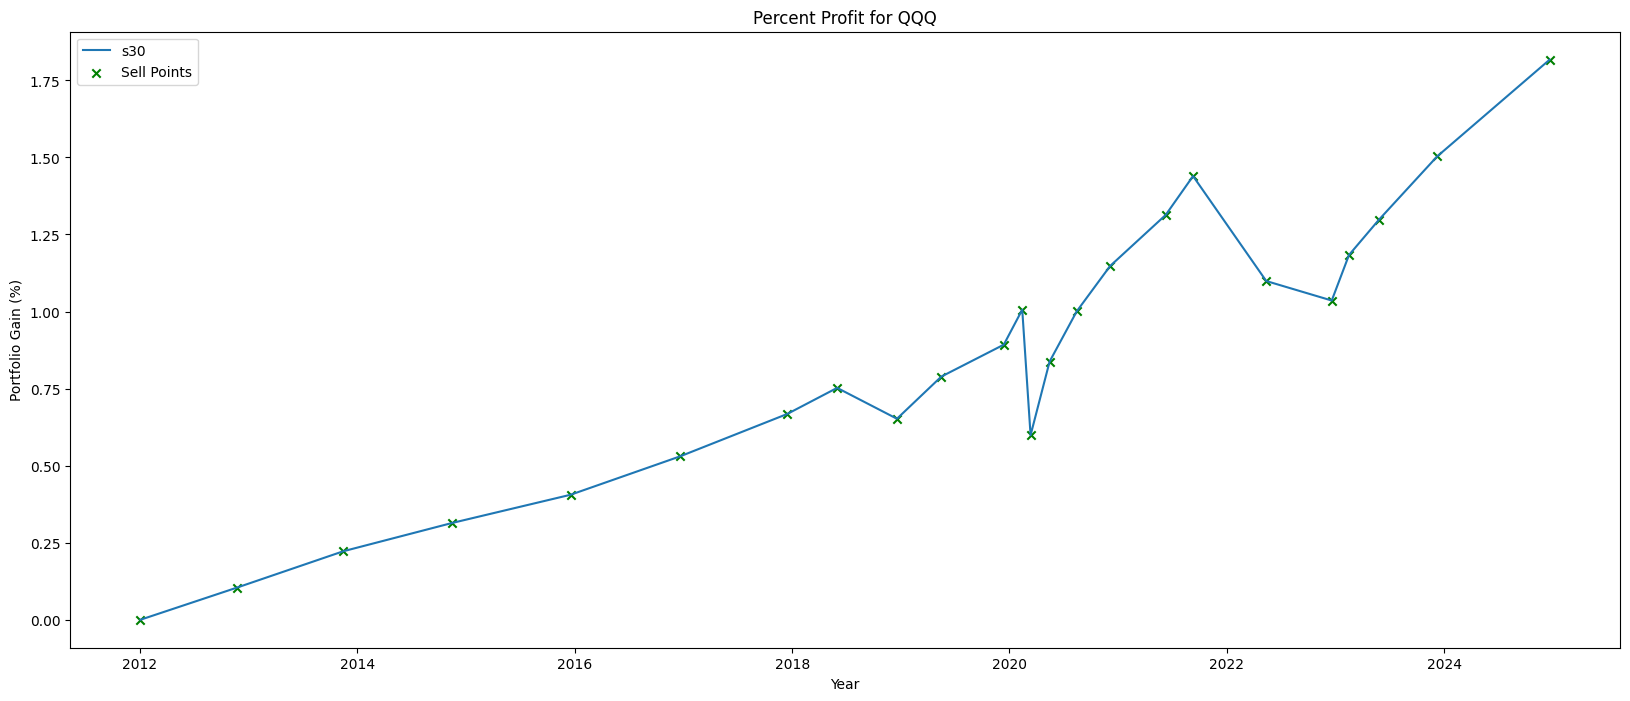

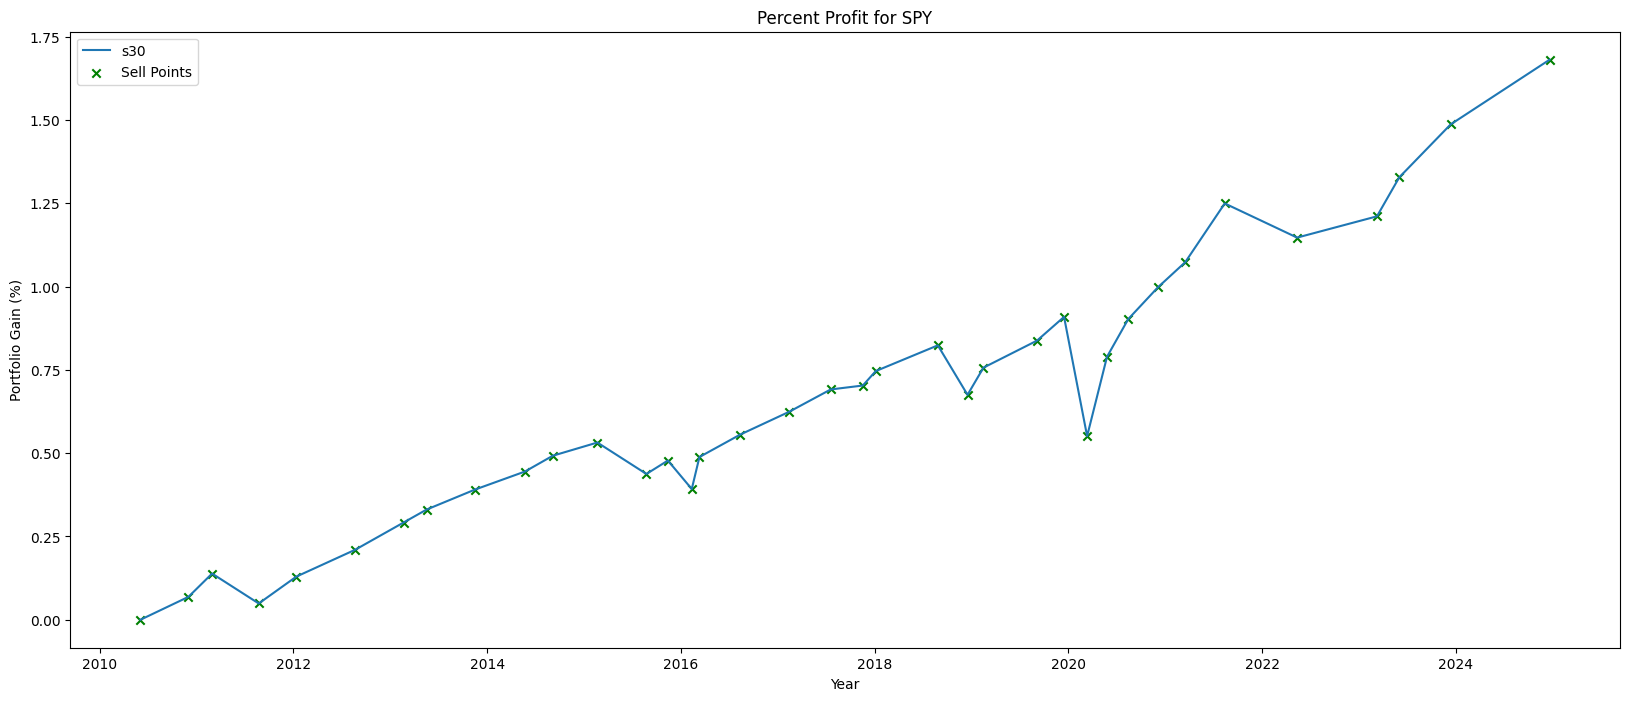

In [214]:
# Iterate through each ticker
for i, TICKER in enumerate(TICKERS):
    plt.figure(figsize=(20, 8))
    plt.title(f'Percent Profit for {TICKER}')
    plt.ylabel('Portfolio Gain (%)')
    plt.xlabel('Year')

    for j, strategy in enumerate(portfolio_results):
        # Extracting data for the current strategy and ticker
        sell_dates = [results['sell_date'] for results in portfolio_results[strategy][TICKER]]
        value = [results['final_value'] / initial_cash - 1 for results in portfolio_results[strategy][TICKER]]

        # Plotting data with ticker as the legend label
        plt.plot(sell_dates, value, label=strategy)
        plt.scatter(sell_dates, value, color='green', marker='x', label='Sell Points' if (j + 1) == len(portfolio_results) else None)

    # Adding legend and displaying the plot
    plt.legend(loc='best')  # Adjust location as necessary
    plt.show()

### Plot Portfolio

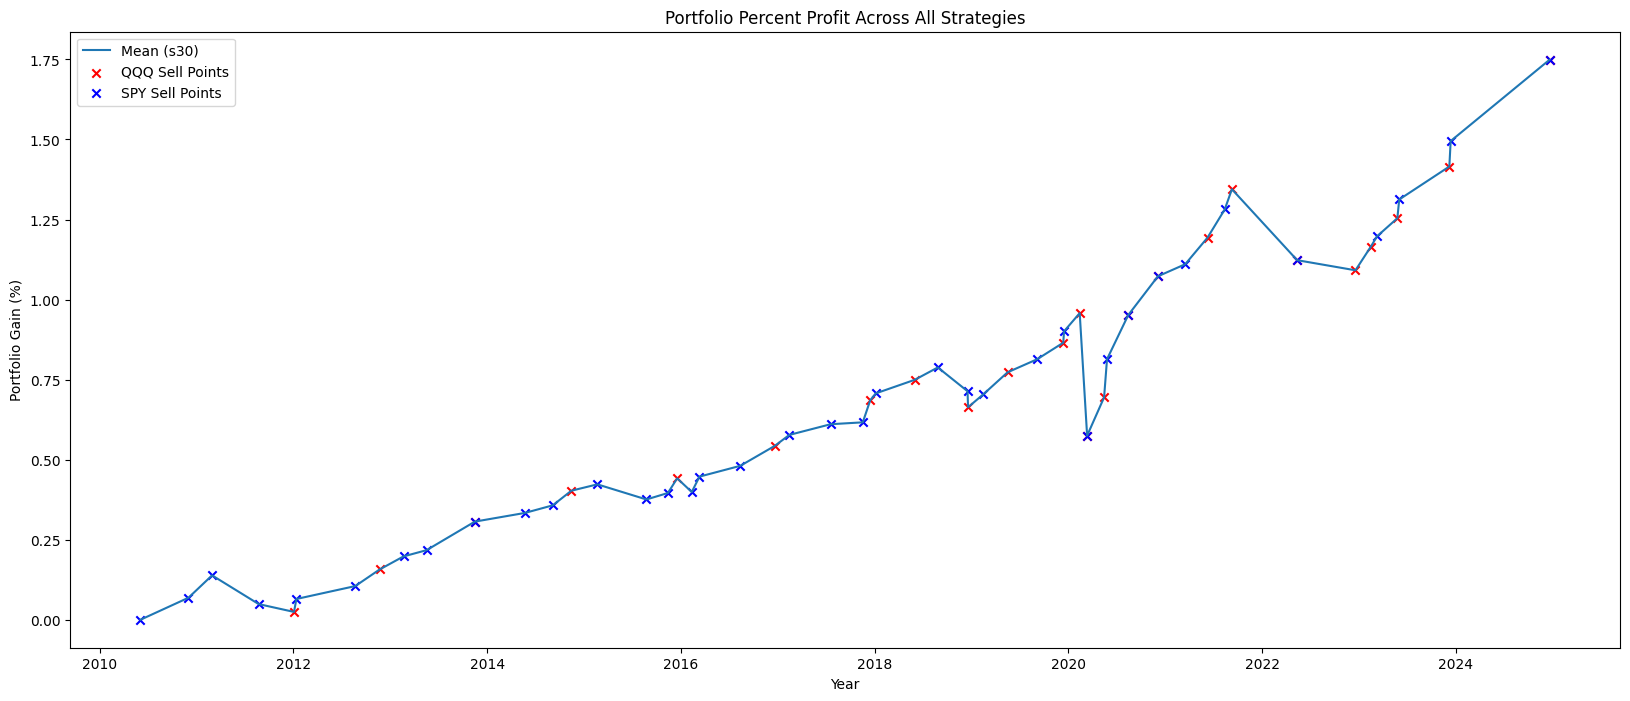

In [215]:
# Colors for scatter points (one per ticker)
ticker_colors = {ticker: color for ticker, color in zip(TICKERS, ['red', 'blue', 'green', 'orange', 'purple'])}

# Initialize the plot
plt.figure(figsize=(20, 8))
plt.title('Portfolio Percent Profit Across All Strategies')
plt.ylabel('Portfolio Gain (%)')
plt.xlabel('Year')

# Iterate through strategies to collect and align data
for j, strategy in enumerate(portfolio_results):
    # Create a DataFrame to store the data for all tickers in the current strategy
    strategy_df = pd.DataFrame()

    for TICKER in TICKERS:
        # Extracting data for the current ticker
        sell_dates = [results['sell_date'] for results in portfolio_results[strategy][TICKER]]
        value = [results['final_value'] / initial_cash - 1 for results in portfolio_results[strategy][TICKER]]

        # Create a DataFrame for the current ticker
        ticker_df = pd.DataFrame({'sell_date': sell_dates, TICKER: value}).set_index('sell_date')

        # Merge with the strategy DataFrame, aligning by dates
        strategy_df = strategy_df.join(ticker_df, how='outer')

    # Forward fill missing values to handle mismatched dates
    strategy_df = strategy_df.sort_index().ffill()

    # Compute the mean across all tickers for the current strategy
    strategy_df['mean_value'] = strategy_df.mean(axis=1)

    # Plot the mean line for the strategy
    plt.plot(strategy_df.index, strategy_df['mean_value'], label=f'Mean ({strategy})', color=f'C{j}')

    # Add scatter points for sell dates, colored by ticker
    for TICKER in TICKERS:
        ticker_sell_dates = [results['sell_date'] for results in portfolio_results[strategy][TICKER]]

        # Align the scatter values with combined_results using sell dates
        ticker_values = strategy_df.loc[ticker_sell_dates, 'mean_value']

        # Scatter plot for each ticker
        plt.scatter(
            ticker_sell_dates, 
            ticker_values, 
            color=ticker_colors[TICKER], 
            marker='x', 
            label=f'{TICKER} Sell Points' if j == 0 else None
        )

plt.legend()
plt.show()

In [216]:
import yfinance as yf
import pandas as pd
import numpy as np

# Define function to calculate annualized volatility
def calculate_annualized_volatility(ticker, start_date, end_date):
    # Download historical price data
    data = yf.download(ticker, start=start_date, end=end_date)
    data = data.copy()['Adj Close']
    print(data)
    print(len(data))
    
    # Calculate daily returns
    data['Daily_Return'] = data.pct_change()
    
    # Calculate standard deviation of daily returns
    daily_volatility = data['Daily_Return'].std()
    
    # Annualize volatility (assuming 252 trading days)
    annualized_volatility = daily_volatility * np.sqrt(252)
    
    return annualized_volatility

tickers = ['SPY']

# Calculate and print annualized volatilities
for ticker in tickers:
    volatility = calculate_annualized_volatility(ticker, pd.to_datetime('2012-01-01'), pd.to_datetime('2023-12-20'))
    print(f"Annualized Volatility for {ticker} from {AFTER_DATE} to {BEFORE_DATE}: {volatility:.2%}")


[*********************100%***********************]  1 of 1 completed

Date
2012-01-03    100.752861
2012-01-04    100.910896
2012-01-05    101.179581
2012-01-06    100.918800
2012-01-09    101.163765
                 ...    
2023-12-13    462.665405
2023-12-14    464.150208
2023-12-15    463.385986
2023-12-18    465.992584
2023-12-19    468.826233
Name: Adj Close, Length: 3011, dtype: float64
3011
Annualized Volatility for SPY from 2000-01-01 00:00:00 to 2025-08-08 00:00:00: 16.73%


In [217]:
TICKER = 'SPY'

underlying = portfolio_option_data[TICKER].loc[(portfolio_option_data[TICKER]['date'] > AFTER_DATE) & (portfolio_option_data[TICKER]['date'] < BEFORE_DATE)].groupby('date').first()['stock_price']


print(underlying.pct_change().dropna().std() * np.sqrt(252))
len(underlying)

0.17461355625305777


3500

### Plot Protection

In [218]:
# Iterate through each ticker first
for TICKER in TICKERS:

    # Iterate through strategies for the current ticker
    for j, strategy in enumerate(portfolio_results):

        # Extract data for the current strategy and ticker
        buy_dates = [results['date'] for results in portfolio_results[strategy][TICKER]]
        sell_dates = [results['sell_date'] for results in portfolio_results[strategy][TICKER]]
        daily_values_i = [results['daily_values_immediate'] / initial_cash - 1 for results in portfolio_results[strategy][TICKER]]
        daily_values = [results['daily_values'] / initial_cash - 1 for results in portfolio_results[strategy][TICKER]]
        final_values = [results['final_value'] / initial_cash - 1 for results in portfolio_results[strategy][TICKER]]

        # Create DataFrames for the current ticker
        ticker_daily_df = pd.concat(daily_values[1:], axis=0).sort_index().to_frame(name='Short Inc')
        ticker_daily_i_df = pd.concat(daily_values_i[1:], axis=0).sort_index().to_frame(name='Acc Val')
        ticker_final_df = pd.DataFrame({'date': sell_dates, 'Leap To Leap': final_values}).set_index('date')

        # Forward fill missing values to handle mismatched dates
        ticker_daily_df = ticker_daily_df.sort_index().ffill().fillna(0)
        ticker_daily_i_df = ticker_daily_i_df.sort_index().ffill().fillna(0)
        ticker_final_df = ticker_final_df.sort_index().ffill().fillna(0)

        # Filter dates as required
        ticker_daily_df = ticker_daily_df.loc[ticker_daily_df.index < BEFORE_DATE]
        ticker_daily_i_df = ticker_daily_i_df.loc[ticker_daily_i_df.index < BEFORE_DATE]
        ticker_final_df = ticker_final_df.loc[ticker_final_df.index < BEFORE_DATE]

        # Stock percent data
        underlying = portfolio_option_data[TICKER].loc[(portfolio_option_data[TICKER]['date'] > AFTER_DATE) & (portfolio_option_data[TICKER]['date'] < BEFORE_DATE)].groupby('date').first()['stock_price']
        underlying_gain = (underlying - underlying.iloc[0]) / underlying.iloc[0]

        # Calculate Max Drawdown for underlying
        underlying_cum_returns = (1 + underlying.pct_change().dropna()).cumprod()
        underlying_peak = underlying_cum_returns.cummax()
        underlying_drawdown = (underlying_cum_returns - underlying_peak) / underlying_peak
        underlying_max_drawdown = underlying_drawdown.min()

        # Calculate Max Drawdown for portfolio
        all_cum_returns = (1 + (pd.concat([returns for returns in daily_values if not returns.empty], axis=0).sort_index() + 1).pct_change().dropna()).cumprod()
        all_peak = all_cum_returns.cummax()
        all_drawdown = (all_cum_returns - all_peak) / all_peak
        all_max_drawdown = all_drawdown.min()

        # Calculate VaR for underlying
        confidence_level = 0.05
        underlying_daily_returns = underlying.pct_change().dropna()
        underlying_var = np.percentile(underlying_daily_returns, 100 * confidence_level)

        # Calculate VaR for portfolio
        all_returns = (pd.concat([returns for returns in daily_values if not returns.empty], axis=0).sort_index() + 1).pct_change().dropna()
        portfolio_var = np.percentile(all_returns, 100 * confidence_level)

        # Calculate Downside Deviation and Sortino Ratio for underlying
        minimum_acceptable_return = 0  # Adjust based on your benchmark
        underlying_excess_negative = underlying_daily_returns[underlying_daily_returns < minimum_acceptable_return]
        underlying_downside_deviation = np.sqrt((underlying_excess_negative ** 2).mean())
        underlying_sortino = (underlying_daily_returns.mean() - minimum_acceptable_return) / underlying_downside_deviation * np.sqrt(252)

        # Calculate Downside Deviation and Sortino Ratio for portfolio
        portfolio_excess_negative = all_returns[all_returns < minimum_acceptable_return]
        portfolio_downside_deviation = np.sqrt((portfolio_excess_negative ** 2).mean())
        portfolio_sortino = (all_returns.mean() - minimum_acceptable_return) / portfolio_downside_deviation * np.sqrt(252)

        # Calculate Calmar Ratio for underlying and portfolio
        underlying_annualized_return = (underlying_cum_returns.iloc[-1] ** (252 / len(underlying_daily_returns)) - 1)
        underlying_calmar = underlying_annualized_return / abs(underlying_max_drawdown)

        portfolio_annualized_return = (all_cum_returns.iloc[-1] ** (252 / len(all_returns)) - 1)
        portfolio_calmar = portfolio_annualized_return / abs(all_max_drawdown)

        # Calculate Sharpe Ratio for underlying
        risk_free_rate_daily = 0.0004 / 252
        underlying_excess_daily_returns = underlying_daily_returns - risk_free_rate_daily
        underlying_daily_sharpe = underlying_excess_daily_returns.mean() / underlying_excess_daily_returns.std()
        underlying_sharpe = underlying_daily_sharpe * np.sqrt(252)

        # Calculate Sharpe Ratio for portfolio
        excess_daily_returns = all_returns - risk_free_rate_daily
        daily_sharpe = excess_daily_returns.mean() / excess_daily_returns.std()
        portfolio_sharpe = daily_sharpe * np.sqrt(252)

        # Metrics Table
        metrics_data = {
            "Metric": [
                "Variance",
                "Max Drawdown",
                "Value at Risk (VaR) at 5% confidence",
                "Downside Deviation",
                "Sortino Ratio",
                "Calmar Ratio",
                "Sharpe Ratio"
            ],
            "Underlying": [
                f"{underlying.pct_change().dropna().std() * np.sqrt(252):.2%}",
                f"{underlying_max_drawdown:.2%}",
                f"{underlying_var:.2%}",
                f"{underlying_downside_deviation:.4f}",
                f"{underlying_sortino:.2f}",
                f"{underlying_calmar:.2f}",
                f"{underlying_sharpe:.2f}"
            ],
            f"{strategy}": [
                f"{all_returns.std() * np.sqrt(252):.2%}",
                f"{all_max_drawdown:.2%}",
                f"{portfolio_var:.2%}",
                f"{portfolio_downside_deviation:.4f}",
                f"{portfolio_sortino:.2f}",
                f"{portfolio_calmar:.2f}",
                f"{portfolio_sharpe:.2f}"
            ]
        }

        # Print the table
        metrics_df = pd.DataFrame(metrics_data)
        print(metrics_df.to_string(index=False))

        print(f"Total Tax Break: {np.sum(np.array([loss['loss_carry_forward'] for loss in portfolio_results[strategy][TICKER]]))}")

        # Mask "No Position" periods for the Acc Val line
        no_position_mask = pd.Series(False, index=ticker_daily_i_df.index)
        for sell, next_buy in zip(sell_dates[:-1], buy_dates[1:]):  # Exclude last sell_date
            no_position_mask.loc[sell:next_buy] = True
        ticker_daily_i_df.loc[no_position_mask, 'Acc Val'] = np.nan  # Mask values during "No Position"

        # Initialize the Plotly figure
        fig = go.Figure()
        c = 1.75
        fig.update_layout(
            width=875 * c,  # Set the width of the chart
            height=350 * c  # Set the height of the chart
        )

        # Add traces for the two lines
        fig.add_trace(go.Scatter(
            x=ticker_daily_df.index,
            y=ticker_daily_df['Short Inc'],
            mode='lines',
            name=f'Short Inc ({strategy})',
            line=dict(color='blue', width=2)
        ))
        fig.add_trace(go.Scatter(
            x=ticker_daily_i_df.index,
            y=ticker_daily_i_df['Acc Val'],
            mode='lines',
            name=f'Acc Val ({strategy})',
            line=dict(color='orange', width=2)
        ))
        # fig.add_trace(go.Scatter(
        #     x=underlying_gain.index,
        #     y=underlying_gain,
        #     mode='lines',
        #     name=f'{TICKER}',
        #     line=dict(color='RED', width=2)
        # ))

        fig.add_trace(go.Scatter(
            x=[None],  # Empty trace for legend entry
            y=[None],
            mode='lines',
            opacity=0.2,
            line=dict(color='gray', width=20),  # Gray line with no width (invisible on the chart)
            name='No Option Position'  # Legend label
        ))

        # Add shaded areas for "No Position" periods
        for sell, next_buy in zip(sell_dates, buy_dates[1:]):  # Include last sell_date
            fig.add_shape(
                type='rect',
                x0=sell,
                x1=next_buy,
                y0=ticker_daily_df['Short Inc'].min(),
                y1=ticker_daily_df['Short Inc'].max(),
                name='No Option Position',
                fillcolor='gray',
                opacity=0.2,
                layer='below',
                line_width=0,
            )


        # # Add vertical lines for buy and sell dates
        # for buy, sell in zip(buy_dates, sell_dates):
        #     fig.add_vline(x=buy, line=dict(color='green', dash='dash'), name='Buy Date')
        #     fig.add_vline(x=sell, line=dict(color='black', dash='dash'), name='Sell Date')

        # # Add hover annotations for active trades (unshaded parts)
        # cum_loss = 0
        # for i, (buy, sell) in enumerate(zip(buy_dates, sell_dates)):
        #     # Retrieve the respective prices for this trade
        #     initial_call_price = portfolio_results[strategy][TICKER][i]['initial_call_price']
        #     last_call_price = portfolio_results[strategy][TICKER][i]['last_call_price']
        #     initial_stock_price = portfolio_results[strategy][TICKER][i]['initial_stock_price']
        #     last_stock_price = portfolio_results[strategy][TICKER][i]['last_stock_price']
        #     loss = portfolio_results[strategy][TICKER][i]['loss_carry_forward']
        #     cum_loss += loss
        #     pct_shield = portfolio_results[strategy][TICKER][i]['pct_shield']

        #     # Create a hover annotation that spans the whole area
        #     fig.add_trace(go.Scatter(
        #         x=[buy, sell, sell, buy],  # Define the corners of the rectangular area
        #         y=[
        #             ticker_daily_df['Short Inc'].min(),
        #             ticker_daily_df['Short Inc'].min(),
        #             ticker_daily_df['Short Inc'].max(),
        #             ticker_daily_df['Short Inc'].max()
        #         ],  # Define the y-coordinates for the rectangle
        #         fill='toself',  # Fill the area within the rectangle
        #         fillcolor='rgba(0,0,0,0)',  # Invisible fill
        #         line=dict(width=0),  # No visible border
        #         hoverinfo='text',  # Show only the text on hover
        #         text=(
        #             f"Trade {i}<br>"
        #             f"Initial Call Price: {initial_call_price:.2f}<br>"
        #             f"Last Call Price: {last_call_price:.2f}<br>"
        #             f"Initial Stock Price: {initial_stock_price:.2f}<br>"
        #             f"Last Stock Price: {last_stock_price:.2f}<br>"
        #             f"Loss Carry: {loss:.2f}<br>"
        #             f"Cum. Loss Carry: {cum_loss:.2f}<br>"
        #             f"Percent Shield: {pct_shield:.2%}"
        #         ),  # Hover text
        #         mode='lines',  # Minimal mode to enable hover without markers
        #         showlegend=False  # Ensure this trace does not appear in the legend
        #     ))

        # Add a textbox in the bottom-right corner with the last value
        last_value = ticker_daily_df['Short Inc'].iloc[-1]
        days_between = (ticker_daily_df.index[-1] - ticker_daily_df.index[0]).days
        APY = (np.log(((last_value + 1) * initial_cash) / initial_cash) / days_between) * 365

        fig.add_annotation(
            x=1,
            y=-0.1,
            text=f"Last Value: {last_value:.2%} | Equivalent APY: {APY:.2%}",
            showarrow=False,
            xref="paper",
            yref="paper",
            font=dict(size=14, color="black"),
            align="right",
            bordercolor="black",
            borderwidth=1,
            borderpad=4,
            bgcolor="white",
            opacity=0.8
        )

        # Set figure layout
        fig.update_layout(
            title=f'Portfolio Percent Profit | {ticker_daily_df.index[0].year} To {ticker_daily_df.index[-1].year} | {strategy} | {TICKER} |',
            xaxis_title='Year',
            yaxis_title='Portfolio Gain (%)',
            legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
            template="plotly_white",
            hovermode="x unified",
        )

        fig.show()


                              Metric Underlying     s30
                            Variance     20.50%  12.81%
                        Max Drawdown    -35.63% -22.78%
Value at Risk (VaR) at 5% confidence     -2.08%  -1.07%
                  Downside Deviation     0.0137  0.0089
                       Sortino Ratio       0.85    0.63
                        Calmar Ratio       0.50    0.37
                        Sharpe Ratio       0.91    0.69
Total Tax Break: 583891.0000000001


                              Metric Underlying     s30
                            Variance     17.46%  11.55%
                        Max Drawdown    -34.32% -24.09%
Value at Risk (VaR) at 5% confidence     -1.68%  -1.02%
                  Downside Deviation     0.0117  0.0081
                       Sortino Ratio       0.64    0.58
                        Calmar Ratio       0.32    0.29
                        Sharpe Ratio       0.68    0.64
Total Tax Break: 438184.0


### Plot Daily Growth For Each Ticker And Portfolio

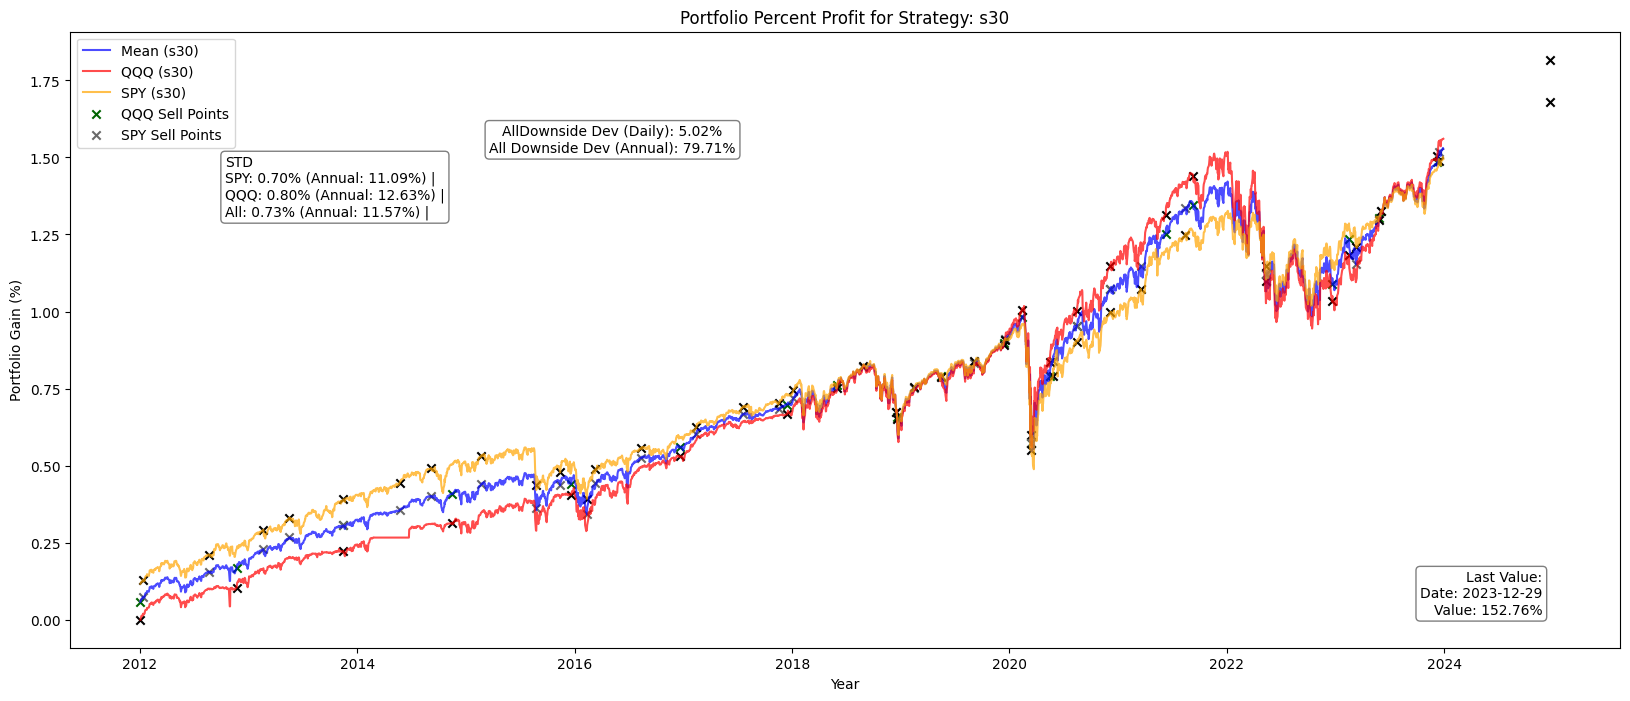

In [219]:
# Initialize a DataFrame to hold all results for each strategy
combined_results = {}
colors = {'SPY': 'dimgrey', 'QQQ': 'darkgreen'}

MAR = 0.05

# Iterate through strategies to collect, align data, and plot one at a time
for j, strategy in enumerate(portfolio_results):
    # Create a DataFrame to store the data for all tickers in the current strategy
    daily_df = pd.DataFrame()
    final_df = pd.DataFrame()

    for TICKER in TICKERS:
        # Extracting data for the current ticker
        sell_dates = [results['sell_date'] for results in portfolio_results[strategy][TICKER]]
        daily_values = [results['daily_values'] / initial_cash - 1 for results in portfolio_results[strategy][TICKER]]
        final_values = [results['final_value'] / initial_cash - 1 for results in portfolio_results[strategy][TICKER]]

        # Create DataFrames for the current ticker
        ticker_daily_df = pd.concat(daily_values[1:], axis=0).sort_index().to_frame(name=TICKER)
        ticker_final_df = pd.DataFrame({'date': sell_dates, TICKER: final_values}).set_index('date')


        ticker_daily_df = ticker_daily_df.loc[ticker_daily_df.index >= pd.to_datetime('2012-01-01')]
        ticker_final_df = ticker_final_df.loc[ticker_final_df.index >= pd.to_datetime('2012-01-01')]

        # Merge with the strategy DataFrames, aligning by dates
        daily_df = daily_df.join(ticker_daily_df, how='outer')
        final_df = final_df.join(ticker_final_df, how='outer')

    # Forward fill missing values to handle mismatched dates
    joined_df = daily_df.join(final_df, how='inner', rsuffix='_final')

    daily_df = daily_df.sort_index().ffill()
    final_df = final_df.sort_index().ffill()

    daily_df = daily_df.fillna(0)
    final_df = final_df.fillna(0)

    # Compute the mean across all tickers for the current strategy
    daily_df['mean_value'] = daily_df.mean(axis=1)
    final_df['mean_value'] = daily_df.mean(axis=1)

    # Filter dates as required
    daily_df = daily_df.loc[daily_df.index < BEFORE_DATE]
    final_df = final_df.loc[final_df.index < BEFORE_DATE]

    # Initialize the plot for the current strategy
    plt.figure(figsize=(20, 8))
    plt.title(f'Portfolio Percent Profit for Strategy: {strategy}')
    plt.ylabel('Portfolio Gain (%)')
    plt.xlabel('Year')

    # Plot the mean line for the strategy
    plt.plot(daily_df.index, daily_df['mean_value'], label=f'Mean ({strategy})', color='blue', alpha=0.7)
    plt.plot(daily_df.index, daily_df['QQQ'], label=f'QQQ ({strategy})', color='red', alpha=0.7)
    plt.plot(daily_df.index, daily_df['SPY'], label=f'SPY ({strategy})', color='orange', alpha=0.7)

    # Add scatter points for sell dates, colored by ticker
    for TICKER in TICKERS:
        ticker_sell_dates = [results['sell_date'] for results in portfolio_results[strategy][TICKER]]

        # Align the scatter values with final_df using sell dates
        valid_sell_dates = [date for date in ticker_sell_dates if date in final_df.index]

        # Scatter plot for each ticker
        plt.scatter(
            valid_sell_dates, 
            final_df.loc[valid_sell_dates, 'mean_value'], 
            color=f'{colors[TICKER]}', 
            marker='x',
            label=f'{TICKER} Sell Points'
        )

        plt.scatter(
            valid_sell_dates, 
            final_df.loc[valid_sell_dates, TICKER], 
            color='black', 
            marker='x',
        )

    # Add textbox with the last value
    last_date = daily_df.index[-1]
    last_value = daily_df['mean_value'].iloc[-1]
    textstr = f'Last Value:\nDate: {last_date.date()}\nValue: {last_value:.2%}'
    plt.text(
        0.95, 0.05,  # Bottom-right corner
        textstr,
        transform=plt.gca().transAxes,
        fontsize=10,
        verticalalignment='bottom',
        horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.5)
    )

    SPY_vol = ((1 + daily_df['SPY']) / (1 + daily_df['SPY'].shift(1)) - 1).std()
    QQQ_vol = ((1 + daily_df['QQQ']) / (1 + daily_df['QQQ'].shift(1)) - 1).std()
    all_vol = ((1 + daily_df['mean_value']) / (1 + daily_df['mean_value'].shift(1)) - 1).std()
    textstr = (
        f"STD\n"
        f"SPY: {SPY_vol:.2%} (Annual: {SPY_vol * np.sqrt(252):.2%}) |\n"
        f"QQQ: {QQQ_vol:.2%} (Annual: {QQQ_vol * np.sqrt(252):.2%}) |\n"
        f"All: {all_vol:.2%} (Annual: {all_vol * np.sqrt(252):.2%}) |"
    )

    plt.text(
        0.1, 0.8,  # Middle of the plot
        textstr,
        transform=plt.gca().transAxes,
        fontsize=10,
        verticalalignment='top',
        horizontalalignment='left',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.5)
    )

    # Calculate downside deviation directly from the expression
    downside_diff = [
        max(0, MAR - r)
        for r in ((1 + daily_df['mean_value']) / (1 + daily_df['mean_value'].shift(1)) - 1).dropna()
    ]
    downside_variance = np.mean([diff**2 for diff in downside_diff])
    downside_deviation_daily = np.sqrt(downside_variance)

    # Annualize downside deviation
    downside_deviation_annual = downside_deviation_daily * np.sqrt(252)

    # Create text for the box
    textstr = (
        f"AllDownside Dev (Daily): {downside_deviation_daily:.2%}\n"
        f"All Downside Dev (Annual): {downside_deviation_annual:.2%}"
    )

    # Add the text box to the plot
    plt.text(
        0.35, 0.8,  # Adjust position as needed
        textstr,
        transform=plt.gca().transAxes,
        fontsize=10,
        verticalalignment='bottom',
        horizontalalignment='center',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.5)
    )

    # Add legend and show the plot for the current strategy
    plt.legend()
    plt.show()
